1. Importing Required Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
import joblib
%matplotlib inline

2. Loading and Inspecting Data

In [5]:
df = pd.read_csv('fake_job_postings.csv')
print(df.info())
df.head()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


3. Data Cleaning


In [6]:
df = df.drop(columns='job_id')
df = df.dropna(subset=['description'])
df['location'] = df['location'].fillna('unknown')
df['company_profile'] = df['company_profile'].fillna('Not Provided')
df['requirements'] = df['requirements'].fillna('Not Specified')
df['benefits'] = df['benefits'].fillna('Not Specified')
df['employment_type'] = df['employment_type'].fillna('other')
df['required_experience'] = df['required_experience'].fillna('Not Specified')
df['required_education'] = df['required_education'].fillna('Not Specified')
df['industry'] = df['industry'].fillna('other')
df['function'] = df['function'].fillna('other')

df = df.drop(columns=['department', 'salary_range', 'telecommuting', 'has_company_logo', 'has_questions'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 17879 entries, 0 to 17879
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17879 non-null  object
 1   location             17879 non-null  object
 2   company_profile      17879 non-null  object
 3   description          17879 non-null  object
 4   requirements         17879 non-null  object
 5   benefits             17879 non-null  object
 6   employment_type      17879 non-null  object
 7   required_experience  17879 non-null  object
 8   required_education   17879 non-null  object
 9   industry             17879 non-null  object
 10  function             17879 non-null  object
 11  fraudulent           17879 non-null  int64 
dtypes: int64(1), object(11)
memory usage: 1.8+ MB
None


5. Data Visualization

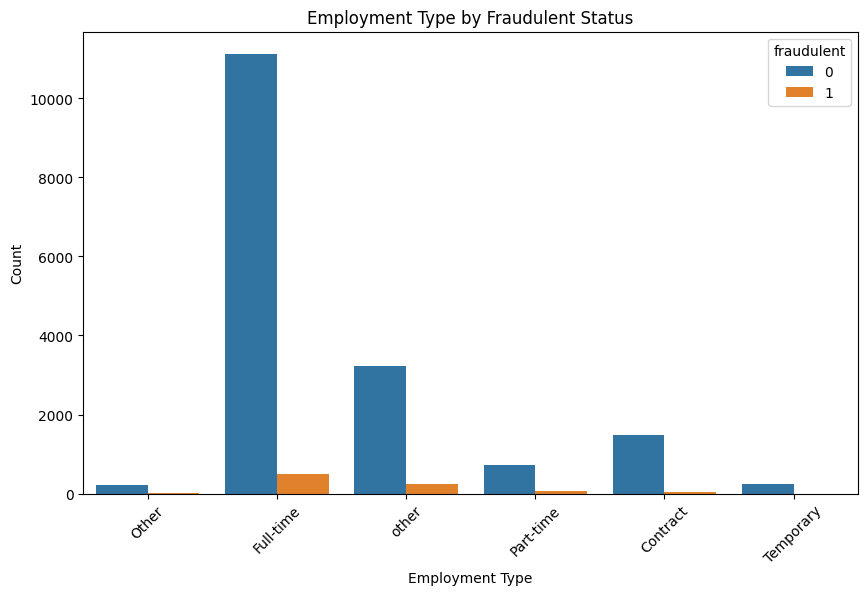

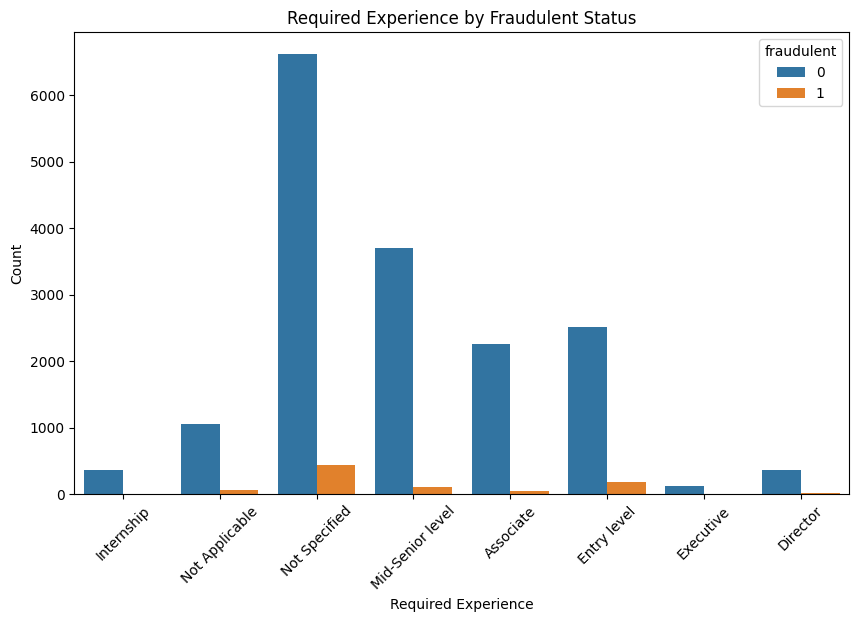

No numerical features available for correlation heatmap.


In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='employment_type', hue='fraudulent')
plt.title('Employment Type by Fraudulent Status')
plt.xlabel('Employment Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.savefig('employment_type_distribution.png')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='required_experience', hue='fraudulent')
plt.title('Required Experience by Fraudulent Status')
plt.xlabel('Required Experience')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.savefig('required_experience_distribution.png')
plt.show()

numeric_columns = df.select_dtypes(include='number').drop(columns=['fraudulent'], errors='ignore')
if not numeric_columns.empty:
    corr = numeric_columns.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Heatmap of Numerical Features')
    plt.savefig('correlation_heatmap.png')
    plt.show()
else:
    print("No numerical features available for correlation heatmap.")

    

6.Feature Selection And Encoding

In [8]:
df = pd.get_dummies(df, columns=['employment_type', 'required_experience', 'required_education', 'industry', 'function'])

X = df.drop(columns=['fraudulent'])
y = df['fraudulent']
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(exclude='object').columns.tolist()

X_le = X.copy()
label_encoders = {}
for col in categorical_cols:
    X_le[col] = X_le[col].astype(str).fillna('Missing')
    le = LabelEncoder()
    X_le[col] = le.fit_transform(X_le[col])
    label_encoders[col] = le

selector = SelectKBest(score_func=chi2, k='all')
selector.fit(X_le[categorical_cols], y)
scores = selector.scores_
score_df = pd.DataFrame({'Feature': categorical_cols, 'Chi2 Score': scores}).sort_values(by='Chi2 Score', ascending=False)
important_categorical_cols = score_df[score_df['Chi2 Score'] > 10]['Feature'].tolist()

selected_features = numeric_cols + important_categorical_cols
X_selected = X_le[selected_features]
print("Selected features:", selected_features)

Selected features: ['employment_type_Contract', 'employment_type_Full-time', 'employment_type_Other', 'employment_type_Part-time', 'employment_type_Temporary', 'employment_type_other', 'required_experience_Associate', 'required_experience_Director', 'required_experience_Entry level', 'required_experience_Executive', 'required_experience_Internship', 'required_experience_Mid-Senior level', 'required_experience_Not Applicable', 'required_experience_Not Specified', 'required_education_Associate Degree', "required_education_Bachelor's Degree", 'required_education_Certification', 'required_education_Doctorate', 'required_education_High School or equivalent', "required_education_Master's Degree", 'required_education_Not Specified', 'required_education_Professional', 'required_education_Some College Coursework Completed', 'required_education_Some High School Coursework', 'required_education_Unspecified', 'required_education_Vocational', 'required_education_Vocational - Degree', 'required_educ

7. Handling Class Imbalance with SMOTE

In [9]:
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_selected, y)
print("Original class distribution:\n", y.value_counts())
print("\nBalanced class distribution:\n", y_balanced.value_counts())
print("Final shape after SMOTE:", X_balanced.shape)

Original class distribution:
 fraudulent
0    17014
1      865
Name: count, dtype: int64

Balanced class distribution:
 fraudulent
0    17014
1    17014
Name: count, dtype: int64
Final shape after SMOTE: (34028, 204)


8. Splitting Data

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=1)
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train: (27222, 204)
Shape of y_train: (27222,)
Shape of x_test: (6806, 204)
Shape of y_test: (6806,)


9. Hyperparameter Tuning

In [11]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 15],
    'min_samples_split': [2]
}
rf_cv = GridSearchCV(RandomForestClassifier(random_state=1, n_jobs=-1), param_grid=param_grid, cv=5, scoring='f1')
rf_cv.fit(x_train, y_train)
print(f"Best parameters: {rf_cv.best_params_}")
print(f"Best F1 score: {rf_cv.best_score_}")

Best parameters: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 100}
Best F1 score: 0.9677146563596809


10.Model Evaluation

Train Accuracy (F1 Score): 0.9677146563596809
Test Accuracy: 0.9689979429914781


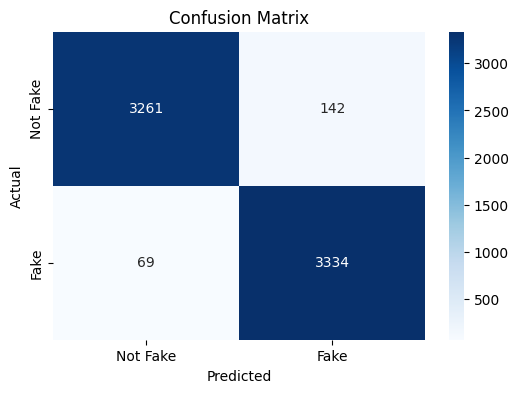

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3403
           1       0.96      0.98      0.97      3403

    accuracy                           0.97      6806
   macro avg       0.97      0.97      0.97      6806
weighted avg       0.97      0.97      0.97      6806



In [12]:
y_pred = rf_cv.best_estimator_.predict(x_test)
print("Train Accuracy (F1 Score):", rf_cv.best_score_)
print("Test Accuracy:", rf_cv.best_estimator_.score(x_test, y_test))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fake', 'Fake'], yticklabels=['Not Fake', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

print(classification_report(y_test, y_pred))

11.Data Visualization: Feature Importance

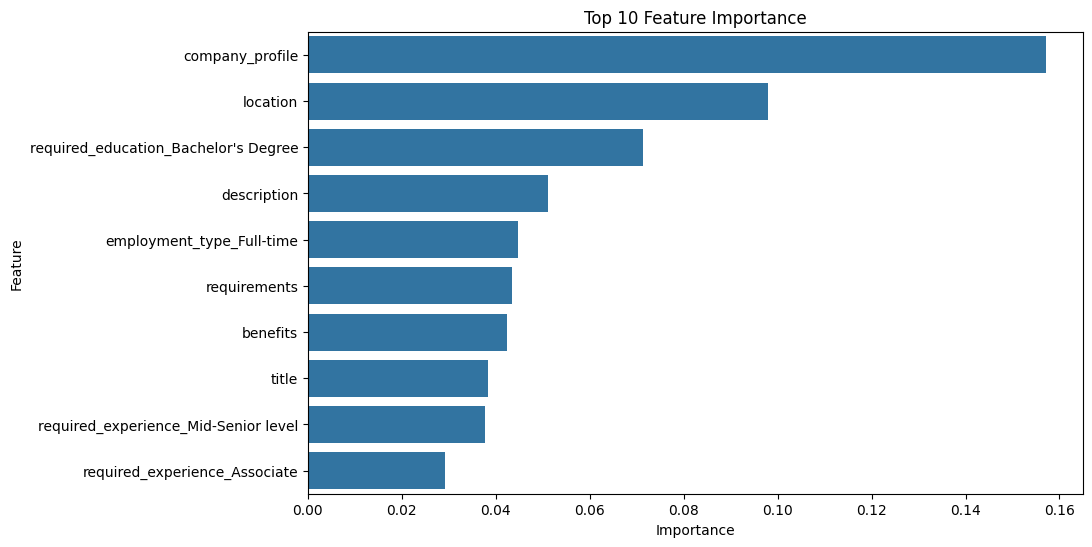

In [13]:
feature_importance = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': rf_cv.best_estimator_.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.savefig('feature_importance.png')
plt.show()

12. Saving the Model

In [14]:
joblib.dump(rf_cv.best_estimator_, 'fake_jobPostings.pkl')
print('Model saved as fake_jobPostings.pkl')

Model saved as fake_jobPostings.pkl
